In [2]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 42.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=fbcb1032c9a630d6942fe2d81e0a0d4b7ec7eb71589b767774b31c47702bada7
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').getOrCreate()

In [6]:
df=spark.read.option('header','true').csv('/content/drive/MyDrive/동준/MSBA/Spring 2022/Big Data/Big Data Project/temp data project/new_flight_v3.csv')

In [ ]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[_c0: string, ITIN_ID: string, MARKET_COUPONS: string, YEAR: string, QUARTER: string, ORIGIN: string, ORIGIN_STATE_NM: string, DEST: string, DEST_STATE_NM: string, AIRPORT_GROUP: string, TK_CARRIER_CHANGE: string, TK_CARRIER_GROUP: string, REPORTING_CARRIER: string, BULK_FARE: string, PASSENGERS: string, MARKET_FARE: string, DISTANCE_GROUP: string, MARKET_MILES_FLOWN: string, ITIN_GEO_TYPE: string, MKT_GEO_TYPE: string]>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
df2=df.selectExpr('cast(ITIN_ID as string) ITIN_ID',\
'cast(MARKET_COUPONS as int) MARKET_COUPONS',\
'cast(YEAR as string) YEAR',\
'cast(QUARTER as string) QUARTER',\
'cast(ORIGIN as string) ORIGIN',\
'cast(ORIGIN_STATE_NM as string) ORIGIN_STATE_NM',\
'cast(DEST as string) DEST',\
'cast(DEST_STATE_NM as string) DEST_STATE_NM',\
'cast(AIRPORT_GROUP as string) AIRPORT_GROUP',\
'cast(TK_CARRIER_CHANGE as boolean) TK_CARRIER_CHANGE',\
'cast(TK_CARRIER_GROUP as string) TK_CARRIER_GROUP',\
'cast(REPORTING_CARRIER as string) REPORTING_CARRIER',\
'cast(BULK_FARE as boolean) BULK_FARE',\
'cast(PASSENGERS as int) PASSENGERS',\
'cast(MARKET_FARE as int) MARKET_FARE',\
'cast(DISTANCE_GROUP as string) DISTANCE_GROUP',\
'cast(MARKET_MILES_FLOWN as int) MARKET_MILES_FLOWN',\
'cast(ITIN_GEO_TYPE as string) ITIN_GEO_TYPE',\
'cast(MKT_GEO_TYPE as string) MKT_GEO_TYPE')

In [16]:
temp=df.selectExpr('cast(ITIN_ID as string) ITIN_ID',\
'cast(MARKET_COUPONS as int) MARKET_COUPONS',\
'cast(YEAR as string) YEAR',\
'cast(QUARTER as string) QUARTER',\
'cast(ORIGIN as string) ORIGIN',\
'cast(ORIGIN_STATE_NM as string) ORIGIN_STATE_NM',\
'cast(DEST as string) DEST',\
'cast(DEST_STATE_NM as string) DEST_STATE_NM',\
'cast(AIRPORT_GROUP as string) AIRPORT_GROUP',\
'cast(TK_CARRIER_CHANGE as int) TK_CARRIER_CHANGE',\
'cast(TK_CARRIER_GROUP as string) TK_CARRIER_GROUP',\
'cast(REPORTING_CARRIER as string) REPORTING_CARRIER',\
'cast(BULK_FARE as boolean) BULK_FARE',\
'cast(PASSENGERS as int) PASSENGERS',\
'cast(MARKET_FARE as int) MARKET_FARE',\
'cast(DISTANCE_GROUP as string) DISTANCE_GROUP',\
'cast(MARKET_MILES_FLOWN as int) MARKET_MILES_FLOWN',\
'cast(ITIN_GEO_TYPE as string) ITIN_GEO_TYPE',\
'cast(MKT_GEO_TYPE as string) MKT_GEO_TYPE')

In [ ]:
from pyspark.sql.functions import *
def getAnovaStats(categoryData) : 
    cat_val = categoryData.toDF("cat","value")
    cat_val.createOrReplaceTempView("df")
    newdf = spark.sql("select A.cat, A.value, cast((A.value * A.value) as double) as valueSq, ((A.value - B.avg) * (A.value - B.avg)) as diffSq from df A join (select cat, avg(value) as avg from df group by cat) B where A.cat = B.cat")
    grouped = newdf.groupBy("cat")
    sums = grouped.sum("value")
    counts = grouped.count()
    numCats = counts.count() 
    sumsq = grouped.sum("valueSq") 
    avgs = grouped.avg("value")
    
    totN = counts.selectExpr("sum(count) as total").rdd.map(lambda x: x.total).collect()[0]
    totSum = sums.selectExpr("sum(`sum(value)`) as totSum").rdd.map(lambda x: x.totSum).collect()[0]
    totSumSq = sumsq.selectExpr("sum(`sum(valueSq)`) as totSumSq").rdd.map(lambda x: x.totSumSq).collect()[0]

    totMean = totSum / totN

    dft = totN - 1
    dfb = numCats - 1
    dfw = totN - numCats
    
    joined = counts.selectExpr("cat as category", "count").join(sums, col("category") == sums.cat, 'inner')\
        .drop(sums.cat)\
        .join(sumsq, col("category") == sumsq.cat, 'inner')\
        .drop(sumsq.cat)\
        .join(avgs, col("category") == avgs.cat, 'inner')\
        .drop(avgs.cat)
    finaldf = joined.withColumn("totMean", lit(totMean))

    ssb_tmp = finaldf.rdd.map(lambda x: (x[0], ((x[4] - x[5])*(x[4] - x[5]))*x[1]))
    ssb = ssb_tmp.toDF().selectExpr("sum(_2) as total").rdd.map(lambda x: x.total).collect()[0]

    ssw_tmp = grouped.sum("diffSq")
    ssw = ssw_tmp.selectExpr("sum(`sum(diffSq)`) as total").rdd.map(lambda x: x.total).collect()[0]
    
    sst = ssb + ssw

    msb = ssb / dfb
    msw = ssw / dfw
    F = msb / msw

    etaSq = ssb / sst
    omegaSq = (ssb - ((numCats - 1) * msw))/(sst + msw)
    return (dfb, dfw, F, etaSq, omegaSq)

In [ ]:
hptest=temp.select(col('MARKET_COUPONS'),col('MARKET_FARE'))

In [ ]:
getAnovaStats(hptest)

(6, 2885161, 5283.619753194923, 0.010868430083423277, 0.010866369353471472)

In [ ]:
df2.printSchema

<bound method DataFrame.printSchema of DataFrame[ITIN_ID: string, MARKET_COUPONS: int, YEAR: string, QUARTER: string, ORIGIN: string, ORIGIN_STATE_NM: string, DEST: string, DEST_STATE_NM: string, AIRPORT_GROUP: string, TK_CARRIER_CHANGE: boolean, TK_CARRIER_GROUP: string, REPORTING_CARRIER: string, BULK_FARE: boolean, PASSENGERS: int, MARKET_FARE: int, DISTANCE_GROUP: string, MARKET_MILES_FLOWN: int, ITIN_GEO_TYPE: string, MKT_GEO_TYPE: string]>

In [20]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

#Label Encoding - string data

In [32]:
si_dest_state_nm=StringIndexer(inputCol='DEST_STATE_NM',outputCol='dest_state_index')
df3=si_dest_state_nm.fit(df2).transform(df2)
df3=df3.drop(col('DEST_STATE_NM'))

si_reporting_carrier=StringIndexer(inputCol='REPORTING_CARRIER',outputCol='reporting_carrier_index')
df3=si_reporting_carrier.fit(df3).transform(df3)
df3=df3.drop(col('REPORTING_CARRIER'))

si_quarter=StringIndexer(inputCol='QUARTER',outputCol='quarter_index')
df3=si_quarter.fit(df3).transform(df3)
df3=df3.drop(col('QUARTER'))

si_distance_group=StringIndexer(inputCol='DISTANCE_GROUP',outputCol='distance_group_index')
df3=si_distance_group.fit(df3).transform(df3)
df3=df3.drop(col('DISTANCE_GROUP'))

si_itin_geotype=StringIndexer(inputCol='ITIN_GEO_TYPE',outputCol='itin_geotype_index')
df3=si_itin_geotype.fit(df3).transform(df3)
df3=df3.drop(col('ITIN_GEO_TYPE'))

si_mkt_geotype=StringIndexer(inputCol='MKT_GEO_TYPE',outputCol='mkt_geotype_index')
df3=si_mkt_geotype.fit(df3).transform(df3)
df3=df3.drop(col('MKT_GEO_TYPE'))

In [33]:
#for the linear regression
si_dest_state_nm=StringIndexer(inputCol='ORIGIN',outputCol='origin_index')
df3=si_dest_state_nm.fit(df3).transform(df3)
df3=df3.drop(col('ORIGIN'))

si_reporting_carrier=StringIndexer(inputCol='ORIGIN_STATE_NM',outputCol='origin_state_index')
df3=si_reporting_carrier.fit(df3).transform(df3)
df3=df3.drop(col('ORIGIN_STATE_NM'))

si_quarter=StringIndexer(inputCol='DEST',outputCol='dest_index')
df3=si_quarter.fit(df3).transform(df3)
df3=df3.drop(col('DEST'))

In [35]:
from pyspark.sql.functions import *

removing=['ITIN_ID','TK_CARRIER_CHANGE','TK_CARRIER_GROUP','YEAR','AIRPORT_GROUP','BULK_FARE','itin_geotype_index','mkt_geotype_index']
for x in removing:
    df3=df3.drop(col(x))

#Since the year column only has '2021', I removed this column.
#I also removed the variables that have huge distinct values.

In [36]:
df3.columns

['MARKET_COUPONS',
 'PASSENGERS',
 'MARKET_FARE',
 'MARKET_MILES_FLOWN',
 'dest_state_index',
 'reporting_carrier_index',
 'quarter_index',
 'distance_group_index',
 'origin_index',
 'origin_state_index',
 'dest_index']

In [41]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import *

indexers_ON = [OneHotEncoder(inputCol=column, outputCol=column+"_Vec")
for column in  ['dest_state_index',
 'reporting_carrier_index',
 'quarter_index',
 'distance_group_index',
 'origin_index',
 'origin_state_index',
 'dest_index'] ]
pipeline = Pipeline(stages=indexers_ON)
df4 = pipeline.fit(df3).transform(df3)
df4.show()

+--------------+----------+-----------+------------------+----------------+-----------------------+-------------+--------------------+------------+------------------+----------+--------------------+---------------------------+-----------------+------------------------+----------------+----------------------+---------------+
|MARKET_COUPONS|PASSENGERS|MARKET_FARE|MARKET_MILES_FLOWN|dest_state_index|reporting_carrier_index|quarter_index|distance_group_index|origin_index|origin_state_index|dest_index|dest_state_index_Vec|reporting_carrier_index_Vec|quarter_index_Vec|distance_group_index_Vec|origin_index_Vec|origin_state_index_Vec| dest_index_Vec|
+--------------+----------+-----------+------------------+----------------+-----------------------+-------------+--------------------+------------+------------------+----------+--------------------+---------------------------+-----------------+------------------------+----------------+----------------------+---------------+
|             1|      

In [42]:
df4.columns

['MARKET_COUPONS',
 'PASSENGERS',
 'MARKET_FARE',
 'MARKET_MILES_FLOWN',
 'dest_state_index',
 'reporting_carrier_index',
 'quarter_index',
 'distance_group_index',
 'origin_index',
 'origin_state_index',
 'dest_index',
 'dest_state_index_Vec',
 'reporting_carrier_index_Vec',
 'quarter_index_Vec',
 'distance_group_index_Vec',
 'origin_index_Vec',
 'origin_state_index_Vec',
 'dest_index_Vec']

In [49]:
from pyspark.ml.feature import VectorAssembler
assemblerInputs = ['MARKET_COUPONS',
 'PASSENGERS',
 'MARKET_MILES_FLOWN',
 'dest_state_index_Vec',
 'reporting_carrier_index_Vec',
 'quarter_index_Vec',
 'distance_group_index_Vec',
 'origin_index_Vec',
 'origin_state_index_Vec',
 'dest_index_Vec']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df5 = assembler.transform(df4)

In [51]:
from pyspark.sql.functions import *
df5=df5.withColumnRenamed("MARKET_FARE", "label")
df5.columns

['MARKET_COUPONS',
 'PASSENGERS',
 'label',
 'MARKET_MILES_FLOWN',
 'dest_state_index',
 'reporting_carrier_index',
 'quarter_index',
 'distance_group_index',
 'origin_index',
 'origin_state_index',
 'dest_index',
 'dest_state_index_Vec',
 'reporting_carrier_index_Vec',
 'quarter_index_Vec',
 'distance_group_index_Vec',
 'origin_index_Vec',
 'origin_state_index_Vec',
 'dest_index_Vec',
 'features']

In [57]:
df5.select('features','label').show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(533,[0,1,2,3,24,...|    0|
|(533,[0,1,2,3,24,...|   32|
|(533,[0,1,2,3,24,...|   48|
|(533,[0,1,2,3,24,...|   49|
|(533,[0,1,2,3,24,...|   53|
|(533,[0,1,2,3,24,...|   58|
|(533,[0,1,2,3,24,...|   78|
|(533,[0,1,2,3,24,...|   88|
|(533,[0,1,2,3,24,...|   32|
|(533,[0,1,2,3,24,...|   49|
|(533,[0,1,2,3,24,...|   55|
|(533,[0,1,2,3,24,...|   56|
|(533,[0,1,2,3,24,...|   58|
|(533,[0,1,2,3,24,...|   58|
|(533,[0,1,2,3,24,...|   73|
|(533,[0,1,2,3,24,...|   88|
|(533,[0,1,2,3,24,...|   88|
|(533,[0,1,2,3,24,...|  151|
|(533,[0,1,2,4,24,...|  383|
|(533,[0,1,2,3,24,...|  155|
+--------------------+-----+
only showing top 20 rows



In [54]:
#LinearRegression
from pyspark.ml.regression import LinearRegression
lr=LinearRegression(labelCol='label', featuresCol='features')

lr_model = lr.fit(df5)
trainingSummary=lr_model.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 131.501694
r2: 0.100455


In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [14]:
from pyspark.sql.functions import *
df3=df3.withColumnRenamed("MARKET_FARE", "label")

In [ ]:
feature_list=[]
for col in df3.columns:
    if (col =='label'):
        continue
    else:
        feature_list.append(col)

assembler=VectorAssembler(inputCols=feature_list, outputCol='features')

In [ ]:
rf=RandomForestRegressor(labelCol='label',featuresCol='features',cacheNodeIds=True)

In [ ]:
pipeline=Pipeline(stages=[assembler,rf])

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder()\
.addGrid(rf.numTrees, [int(x) for x in np.linspace(start=30, stop = 50, num=1)])\
.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start=15, stop=30, num=3)])\
.build()

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval=CrossValidator(estimator=pipeline\
                        ,estimatorParamMaps=paramGrid\
                        , evaluator=RegressionEvaluator()\
                        , numFolds=3)

In [ ]:
# Splitting the data
train, test = df3.randomSplit([0.7,0.3])

In [ ]:
cvModel=crossval.fit(train)

In [ ]:
predictions=cvModel.transform(test)

In [ ]:
evaluator=RegressionEvaluator(labelCol='label',predictionCol='prediction',metricName='r2')

In [ ]:
r2=evaluator.evaluate(predictions)

In [ ]:
rfPred=cvModel.transform(test)

In [ ]:
print(r2)

0.1263582478936628


In [ ]:
from pyspark.sql.functions import *
new_rfPred=rfPred.select(col('label'),col('prediction'))

In [ ]:
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled','true')
spark.conf.set('spark.sql.execution.arrow.pyspark.fallback.enabled','true')

In [ ]:
new_rfResult=new_rfPred.toPandas()

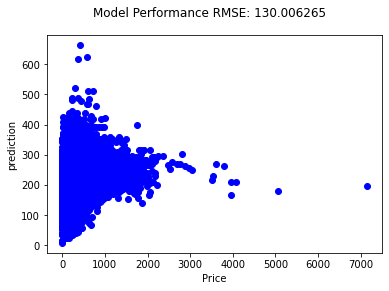

In [ ]:
import matplotlib.pyplot as plt

plt.plot(new_rfResult.label, new_rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

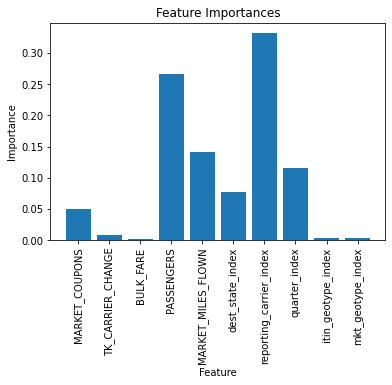

In [ ]:
bestPipeline=cvModel.bestModel
bestModel=bestPipeline.stages[1]

importances=bestModel.featureImportances

x_values=list(range(len(importances)))

plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')

In [ ]:
print('numTrees -', bestModel.getNumTrees)
print('maxDepth -', bestModel.getOrDefault('maxDepth'))

numTrees - 30
maxDepth - 22
